In [45]:
%pip install scikit-learn
%pip install tensorflow
%pip install spacy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------- -------------- 8.1/12.8 MB 45.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 44.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Librerias y dependencias

In [82]:
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import re
from nltk.stem import WordNetLemmatizer
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt


## Procesamiento de datos

In [ ]:
## Labels to predict
##['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative','Neutral']
##['Extremely Negative', 'Negative', 'Positive','Extremely Positive']
##[          0    ,    1         ] -

In [23]:
train=pd.read_csv(r'Corona_NLP_train.csv', encoding='latin')
test=pd.read_csv(r'Corona_NLP_test.csv', encoding='latin')

In [24]:
train=train[train['Sentiment']!='Neutral']
test=test[test['Sentiment']!='Neutral']

In [25]:
x_train=train['OriginalTweet']
y_train=train['Sentiment']

x_test=test['OriginalTweet']
y_test=test['Sentiment']

In [26]:
test['Sentiment'].value_counts()

Sentiment
Negative              1041
Positive               947
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64

In [27]:
replace_marks = {
    'Extremely Negative': 0,
    'Negative': 0,
    'Positive': 1,
    'Extremely Positive': 1
}


In [28]:
def replace_n_binarize(list):
    return list.replace(replace_marks)

In [29]:
y_train=replace_n_binarize(y_train)
y_test=replace_n_binarize(y_test)

C:\Users\PC\AppData\Local\Temp\ipykernel_8476\1761825692.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return list.replace(replace_marks)


## Starting with NLP 

1. Pipeline for transform data to arrays (Tokenization)


_**Pipeline**_

todo a lower &rarr; remover caracteres epeciales &rarr; lematizacion &rarr; TfidfVectorizer

In [30]:
# Todo a Lower
x_train=x_train.apply(lambda x: x.lower())
x_test=x_test.apply(lambda x: x.lower())

In [31]:
#Remover Caracteres especiales
x_train=x_train.apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x))
x_test=x_test.apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x))

In [44]:
spacy.info

<function spacy.cli.info.info(model: Optional[str] = None, *, markdown: bool = False, silent: bool = True, exclude: Optional[List[str]] = None, url: bool = False) -> Union[str, dict]>

In [46]:
# lematizacion
nlp=spacy.load('en_core_web_sm')

def lemmatize_string(strings):
    lemmatized=[]
    for sentence in strings:
        doc=nlp(sentence)
        lemmatized_words = [token.lemma_ for token in doc]
        lemmatized.append(' '.join(lemmatized_words))
    return lemmatized

In [48]:
len(x_train)

33444

In [49]:
len(x_test)

3179

In [50]:
x_train_lemm=lemmatize_string(x_train)
x_test_lemm=lemmatize_string(x_test)

In [51]:
cv=CountVectorizer(stop_words='english')

x_train_vect=cv.fit_transform(x_train_lemm)
x_test_vect=cv.transform(x_test_lemm)

In [52]:
tv=TfidfTransformer()

x_train_pred=tv.fit_transform(x_train_vect)
x_test_pred=tv.transform(x_test_vect)

In [53]:
#First Try with a Log Regression
clf=LogisticRegression(max_iter=500)
clf.fit(x_train_pred, y_train)
y_pred=clf.predict(x_test_pred)

accuracy=accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy)


Accuracy: 0.8379993708713432


In [54]:
feature_names = np.array(cv.get_feature_names_out())
sorted_coef_index = clf.coef_[0].argsort()
print('Coefs Fake : \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))
print()
print('Coefs True :\n{}\n'.format(feature_names[sorted_coef_index[:20]]))

Coefs Fake : 
['help' 'thank' 'free' 'great' 'hand' 'like' 'safe' 'good' 'support'
 'love' 'positive' 'friend' 'care' 'relief' 'share' 'confidence' 'hope'
 'special' 'save' 'hero']

Coefs True :
['crisis' 'panic' 'scam' 'kill' 'bad' 'fear' 'stop' 'die' 'shit' 'fight'
 'sick' 'emergency' 'war' 'fuck' 'hell' 'risk' 'low' 'struggle' 'poor'
 'problem']



 ## Despues de realizar NLP, vamos a entrenar una red neuronal para las predicciones

In [75]:

input_dim = x_train_pred.shape[1]

#Iniciamos a crear la arquitectura de nuestra red neuronal 
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim), # Capa Oculta con capa input 
    Dropout(0.3),  
    Dense(64, activation='relu'),  # Segunda Capa Oculta
    Dropout(0.3), #Los dropouts reducen el sobre ajuste
    Dense(1, activation='sigmoid')  # Capa de salida para que retorne 1s y 0s
])
# Compilar el modelo
model.compile(
    optimizer='rmsprop',  
    loss='binary_crossentropy',
    metrics=['accuracy']  
)

# Entrenar el modelo
nn_fit = model.fit(
    x_train_pred, y_train,
    epochs=5,  # Número de épocas
    batch_size=32,  
    validation_data=(x_test_pred, y_test),  # Validación con x_test
    verbose=1
)

Epoch 1/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 57s 54ms/step - accuracy: 0.7377 - loss: 0.5186 - val_accuracy: 0.8314 - val_loss: 0.3779
Epoch 2/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.8941 - loss: 0.2728 - val_accuracy: 0.8415 - val_loss: 0.3801
Epoch 3/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 57s 54ms/step - accuracy: 0.9183 - loss: 0.2264 - val_accuracy: 0.8367 - val_loss: 0.3822
Epoch 4/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step - accuracy: 0.9354 - loss: 0.1925 - val_accuracy: 0.8411 - val_loss: 0.3952
Epoch 5/5
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 56s 54ms/step - accuracy: 0.9477 - loss: 0.1667 - val_accuracy: 0.8421 - val_loss: 0.4059


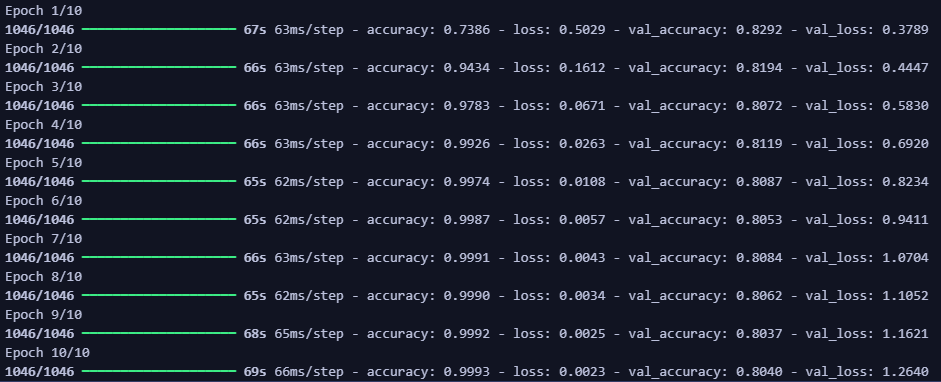

Se tuvo como primer resultado un sobre ajuste por lo que se decidio reducir el numero de epocas

In [76]:
#Metricas de desempeño
loss, accuracy = model.evaluate(x_test_pred, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8382 - loss: 0.4149
Loss: 0.405890554189682, Accuracy: 0.8420886993408203


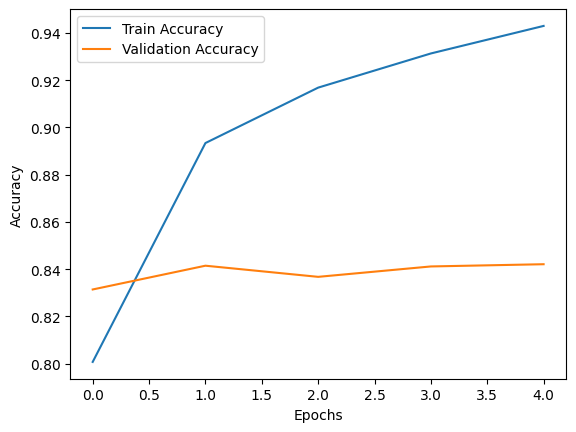

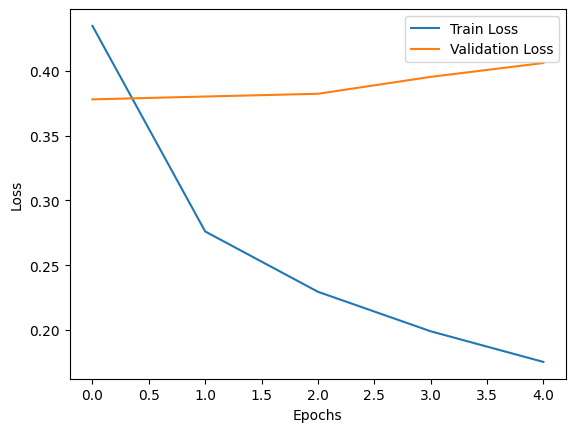

In [77]:
#Para visualizar el comportamiento del accuracy de la NN
import matplotlib.pyplot as plt

# Graficar accuracy
plt.plot(nn_fit.history['accuracy'], label='Train Accuracy')
plt.plot(nn_fit.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(nn_fit.history['loss'], label='Train Loss')
plt.plot(nn_fit.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Predicciones

In [78]:
predictions = model.predict(x_test_pred)
print (np.argmax(predictions[1])) # clase más probable
print (predictions)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
0
[[0.7027111 ]
 [0.99765646]
 [0.99999577]
 ...
 [0.8689649 ]
 [0.00749666]
 [0.9998821 ]]


In [80]:
binary_predictions = (predictions > 0.5).astype(int)

In [83]:
# Reporte de clasificación
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1633
           1       0.82      0.86      0.84      1546

    accuracy                           0.84      3179
   macro avg       0.84      0.84      0.84      3179
weighted avg       0.84      0.84      0.84      3179

